<a href="https://colab.research.google.com/github/jawadsatti320/Crash_game_prediction/blob/main/train_crash_predictor_multi_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Crash Game Multiplier Predictor

This notebook trains a neural network to predict crash game multipliers using historical data.

In [ ]:
!nvidia-smi

Tue Aug 19 13:27:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q torch torchvision torchaudio pandas scikit-learn matplotlib seaborn optuna joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib
from google.colab import files

In [ ]:
uploaded = files.upload()
df = pd.read_csv('crash_data.csv')

Saving crash_data.csv to crash_data.csv


In [ ]:
# Basic cleaning
df['multiplier'] = df['crashpoint']
df['timestamp'] = pd.to_datetime(df['startTime'], format='%a, %d %b %Y %H:%M:%S GMT')
df = df.drop(columns=['nextRoundIn', 'elapsed', 'cashedIn_count', 'cashedOut_count', 'startTime', 'crashpoint'])

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

In [ ]:
# Advanced temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['timestamp'].dt.month
df['quarter'] = df['timestamp'].dt.quarter

In [ ]:
# Rolling statistics and lags
df['multiplier_rolling_mean_5'] = df['multiplier'].shift(1).rolling(window=5, min_periods=1).mean().fillna(1)
df['multiplier_rolling_std_5'] = df['multiplier'].shift(1).rolling(window=5, min_periods=1).std().fillna(0)
df['multiplier_rolling_mean_10'] = df['multiplier'].shift(1).rolling(window=10, min_periods=1).mean().fillna(1)
df['multiplier_rolling_std_10'] = df['multiplier'].shift(1).rolling(window=10, min_periods=1).std().fillna(0)
df['multiplier_ewm'] = df['multiplier'].shift(1).ewm(span=5, adjust=False).mean().fillna(1)

for lag in [1,2,3]:
    df[f'multiplier_lag_{lag}'] = df['multiplier'].shift(lag).fillna(1)

df['multiplier_diff'] = (df['multiplier'].shift(1)-df['multiplier'].shift(2)).fillna(0)

df = df.dropna()

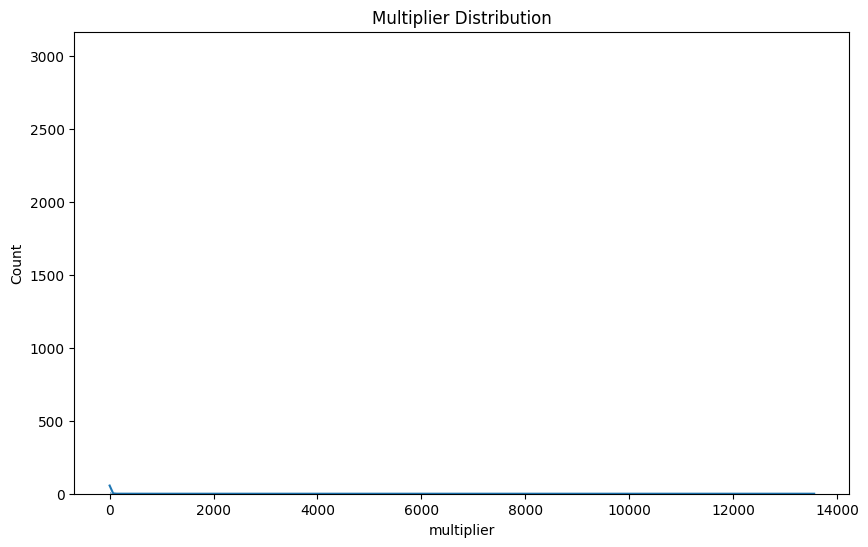

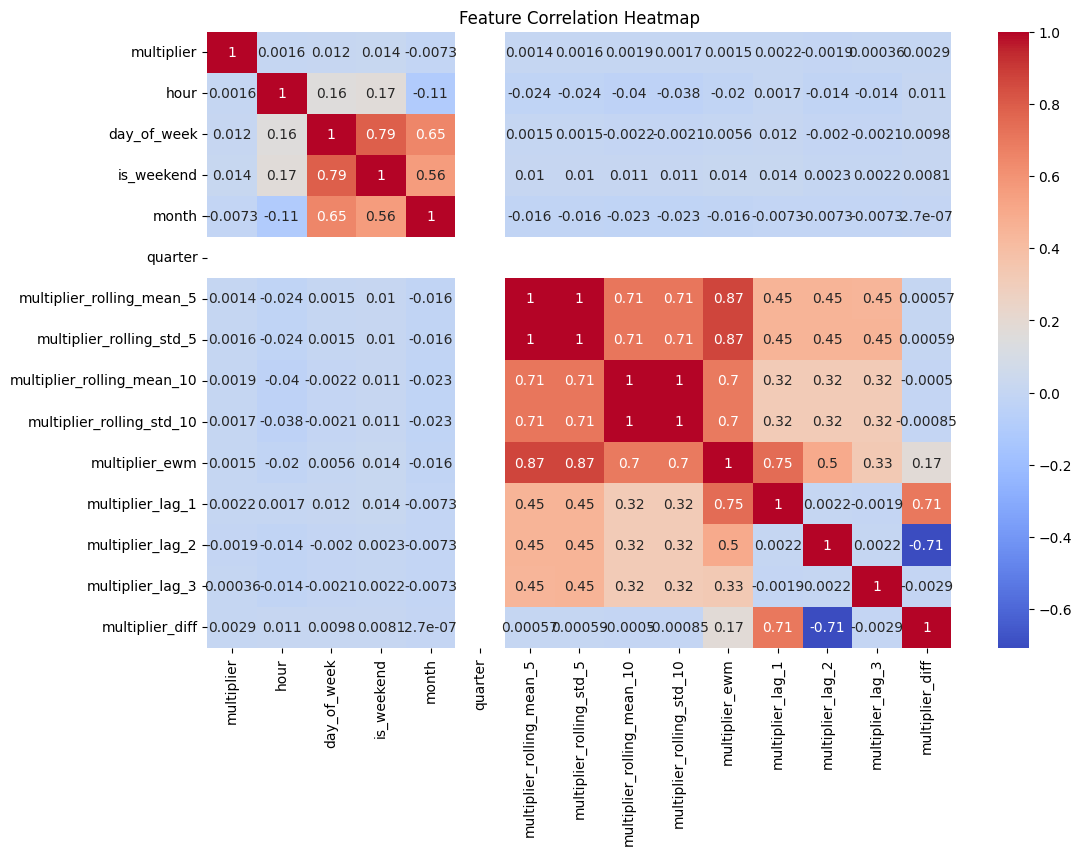

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['multiplier'], kde=True)
plt.title('Multiplier Distribution')
plt.show()

plt.figure(figsize=(12,8))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
features = ['hour','day_of_week','is_weekend','month','quarter','multiplier_rolling_mean_5','multiplier_rolling_std_5','multiplier_rolling_mean_10','multiplier_rolling_std_10','multiplier_ewm','multiplier_lag_1','multiplier_lag_2','multiplier_lag_3','multiplier_diff']
X = df[features]
y = df['multiplier']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class AdvancedCrashPredictor(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, dropout=0.3):
        super(AdvancedCrashPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return torch.relu(x)+1

In [ ]:
def objective(trial):
    hidden_size1 = trial.suggest_int('hidden_size1',64,256)
    hidden_size2 = trial.suggest_int('hidden_size2',32,128)
    dropout = trial.suggest_float('dropout',0.1,0.5)
    lr = trial.suggest_loguniform('lr',1e-5,1e-2)

    model = AdvancedCrashPredictor(input_size=X_train.shape[1],hidden_size1=hidden_size1,hidden_size2=hidden_size2,dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    y_pred=[]
    with torch.no_grad():
        for inputs,_ in test_loader:
            outputs=model(inputs)
            y_pred.extend(outputs.cpu().numpy().flatten())

    return mean_squared_error(y_test,y_pred)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=20)
best_params = study.best_params
print(best_params)

[I 2025-08-19 13:33:28,559] A new study created in memory with name: no-name-1849c7e3-a80c-4b58-8f79-630daf8bae99
/tmp/ipython-input-1363476506.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr',1e-5,1e-2)
[I 2025-08-19 13:33:39,417] Trial 0 finished with value: 93807.03895833218 and parameters: {'hidden_size1': 249, 'hidden_size2': 115, 'dropout': 0.428438272505303, 'lr': 1.1969011500397707e-05}. Best is trial 0 with value: 93807.03895833218.
/tmp/ipython-input-1363476506.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr',1e-5,1e-2)
[I 2025-08-19 13:33:45,374] Trial 1 finished with value: 93658.611

{'hidden_size1': 156, 'hidden_size2': 67, 'dropout': 0.3363058984816645, 'lr': 0.00791492729043717}


In [ ]:
model = AdvancedCrashPredictor(input_size=X_train.shape[1],hidden_size1=best_params['hidden_size1'],hidden_size2=best_params['hidden_size2'],dropout=best_params['dropout'])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=5,verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
epochs=300
train_losses=[]
val_losses=[]
best_val_loss=float('inf')

for epoch in range(epochs):
    model.train()
    train_loss=0
    for inputs,labels in train_loader:
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    train_loss/=len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss=0
    with torch.no_grad():
        for inputs,labels in test_loader:
            outputs=model(inputs)
            val_loss+=criterion(outputs,labels).item()
    val_loss/=len(test_loader)
    val_losses.append(val_loss)

    if val_loss<best_val_loss:
        best_val_loss=val_loss
        torch.save(model.state_dict(),'model_best.pth')
        print(f"Saved best model epoch {epoch+1} Val Loss {val_loss:.4f}")
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{epochs} Train Loss {train_loss:.4f} Val Loss {val_loss:.4f}")

Saved best model epoch 1 Val Loss 92547.6146
Epoch 1/300 Train Loss 9734.1871 Val Loss 92547.6146
Saved best model epoch 2 Val Loss 92535.1041
Epoch 2/300 Train Loss 9724.1470 Val Loss 92535.1041
Saved best model epoch 3 Val Loss 92519.1796
Epoch 3/300 Train Loss 9716.0716 Val Loss 92519.1796
Epoch 4/300 Train Loss 9721.0694 Val Loss 92551.0879
Epoch 5/300 Train Loss 9714.4365 Val Loss 92553.3331
Epoch 6/300 Train Loss 9714.5973 Val Loss 92535.8624
Epoch 7/300 Train Loss 9718.5670 Val Loss 92550.5396
Epoch 8/300 Train Loss 9719.9400 Val Loss 92542.1325
Epoch 9/300 Train Loss 9720.0400 Val Loss 92532.1243
Saved best model epoch 10 Val Loss 92511.0413
Epoch 10/300 Train Loss 9713.0181 Val Loss 92511.0413
Epoch 11/300 Train Loss 9713.8714 Val Loss 92525.5938
Epoch 12/300 Train Loss 9714.4057 Val Loss 92533.0882
Epoch 13/300 Train Loss 9716.5848 Val Loss 92532.4104
Epoch 14/300 Train Loss 9715.5252 Val Loss 92534.2453
Epoch 15/300 Train Loss 9717.7281 Val Loss 92531.3257
Epoch 16/300 Train

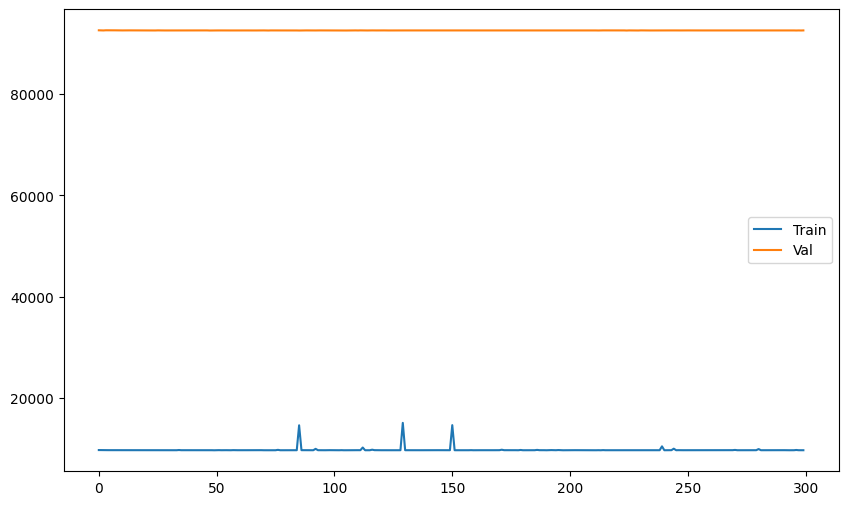

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_losses,label='Train')
plt.plot(val_losses,label='Val')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('model_best.pth'))
model.eval()

y_preds=[]
y_true=[]
with torch.no_grad():
    for xb,yb in test_loader:
        out=model(xb).cpu().numpy().ravel()
        y_preds.extend(out.tolist())
        y_true.extend(yb.cpu().numpy().ravel().tolist())

mse=mean_squared_error(y_true,y_preds)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_true,y_preds)
r2=r2_score(y_true,y_preds)

print(mse,rmse,mae,r2)

accurate=[abs(p-t)/t<0.2 for p,t in zip(y_preds,y_true) if t!=0]
custom_acc=(sum(accurate)/len(accurate))*100 if accurate else 0
print(f"Custom Accuracy {custom_acc:.2f}%")

93635.43558378758 305.9990777498971 19.209779058844607 7.946567535654925e-05
Custom Accuracy 3.04%


In [ ]:
output_dir='model_artifacts'
os.makedirs(output_dir,exist_ok=True)
scaler_path=os.path.join(output_dir,'advanced_scaler.pkl')
model_path=os.path.join(output_dir,'advanced_crash_predictor_model.pth')
joblib.dump(scaler,scaler_path)
torch.save(model.state_dict(),model_path)
print('Saved artifacts')
try:
    files.download(model_path)
    files.download(scaler_path)
except Exception as e:
    print(e)

Saved artifacts


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class AdvancedCrashPredictor(nn.Module):
    def __init__(self,input_size,hidden_size1=128,hidden_size2=64,dropout=0.3):
        super(AdvancedCrashPredictor,self).__init__()
        self.fc1=nn.Linear(input_size,hidden_size1)
        self.bn1=nn.BatchNorm1d(hidden_size1)
        self.fc2=nn.Linear(hidden_size1,hidden_size2)
        self.bn2=nn.BatchNorm1d(hidden_size2)
        self.fc3=nn.Linear(hidden_size2,1)
        self.dropout=nn.Dropout(dropout)
    def forward(self,x):
        x=torch.relu(self.bn1(self.fc1(x)))
        x=self.dropout(x)
        x=torch.relu(self.bn2(self.fc2(x)))
        x=self.dropout(x)
        x=self.fc3(x)
        return torch.relu(x)+1

In [ ]:
scaler=joblib.load(scaler_path)
input_size=scaler.mean_.shape[0]
model=AdvancedCrashPredictor(input_size=input_size,hidden_size1=best_params['hidden_size1'],hidden_size2=best_params['hidden_size2'],dropout=best_params['dropout'])
model.load_state_dict(torch.load(model_path))
model.eval()

AdvancedCrashPredictor(
  (fc1): Linear(in_features=14, out_features=156, bias=True)
  (bn1): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=156, out_features=67, bias=True)
  (bn2): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=67, out_features=1, bias=True)
  (dropout): Dropout(p=0.3363058984816645, inplace=False)
)

In [ ]:
def test_manual(input_data):
    if len(input_data)!=input_size:
        print(f"Error input length {len(input_data)} expected {input_size}")
        return None
    scaled=scaler.transform(np.array(input_data,dtype=np.float32).reshape(1,-1))
    x=torch.tensor(scaled,dtype=torch.float32)
    with torch.no_grad():
        pred=model(x).item()
    return pred

manual_input=[8,6,7,3,2,1,1.0,5.4,6.6,7.9,3.3,2.3,4.1,3.3]
prediction=test_manual(manual_input)
if prediction: print('Predicted Next Multiplier',prediction)

Predicted Next Multiplier 13.039253234863281


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [2]:
from google.colab import files
import os

# Get the current notebook path
notebook_path = os.path.abspath("__main__")

# Download the notebook
try:
    files.download(notebook_path)
except Exception as e:
    print(e)

Cannot find file: /content/__main__
